In [ ]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from custom_resnet.custom_resnet import Model_Net, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = Model_Net(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))
#from torchviz import make_dot
#x = torch.zeros(1,3,32,32,dtype=torch.float, requires_grad=False)
#y  = cifar_10_model(x)
#cifar_model_dot = make_dot(y.mean(), params = dict(list(cifar_10_model.named_parameters())))
#cifar_model_dot.format='png'
#cifar_model_dot.render("model_dot_representation.png")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
          Dropout-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

/home/jyani/ERA_V1/session_10/custom_resnet/custom_resnet.py:149: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [28]:
train_transforms = A.Compose(
    [
        #A.augmentations.crops.transforms.RandomCrop(4,4),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [29]:
torch.manual_seed(1)
batch_size = 64
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

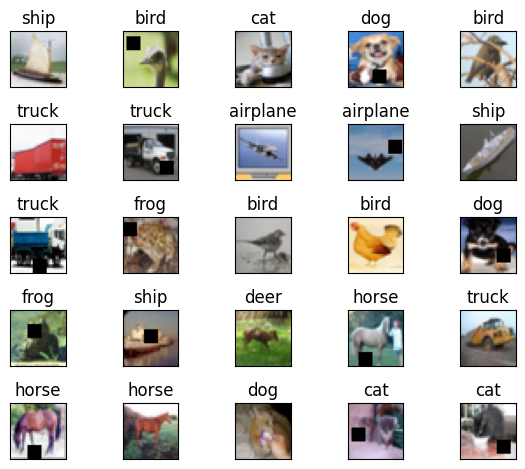

In [30]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [ ]:
drop_out = 0.05
num_epochs=30
model_bn = Model_Net(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.1,verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    scheduler.step(this_loss)
target_test_acc = 85.


Plot results for Batch Norm experiment

In [ ]:
plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Print Training Log

In [ ]:
def print_train_log(train_acc, test_acc, train_loss, test_loss):
    print(f"\nEpoch\t     Train Loss\t     Val Loss     Train Accuracy    Val Accuracy")
    print(f"========================================================================")
    for cnt in range(len(train_acc)):
        print(f"{cnt+1}\t\t{train_loss[cnt]:0.2f}\t\t{test_loss[cnt]:0.2f}\t\t{train_acc[cnt]:0.2f}\t\t{test_acc[cnt]:0.2f}\n")

    print(f"=========================================================================")


In [ ]:
print_train_log(train_acc_bn, test_acc_bn, train_losses_bn, test_losses_bn)